<a href="https://colab.research.google.com/github/zakkaizzatur/Data-Related-Projects/blob/main/Cat%20Dog%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat and Dog image recognition. 
#### Introduction
In this notebook I produce an image classification model to decide if the image is of that of a cat or a dog.

### Importing the Libraries and downloading the data

In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
URL = 'https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

### Creating the dataset and standarizing it.
RGB channel is between 1 and 255. For neural networks we need it to be between 0 and 1. So we create and image generator that rescales the image when applied.

In [ ]:
train_image_generator = ImageDataGenerator(
        rescale=1./255,
        )

validation_image_generator = ImageDataGenerator(
        rescale=1./255,
        )

test_image_generator = ImageDataGenerator(
    rescale=1./255
)

train_data_gen = train_image_generator.flow_from_directory(
        train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(
        validation_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(
        PATH,
        classes=['test'],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=1,
        class_mode=None,
        shuffle=False)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


#### Creating Image generators.
Plot images is used to print the images below. Here I print 5 randam images to inspect.

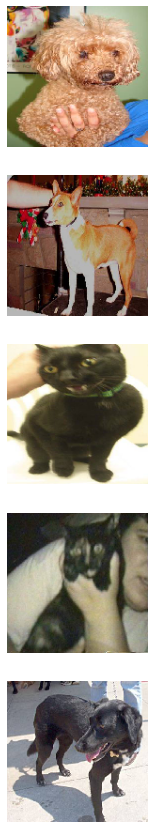

In [ ]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


There is a small number of images. To prevent overfitting, an image generator is created. This image generator takes a single image and return many more by appling random transforation to it. Such as flipping it.

In [ ]:
train_image_generator = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        featurewise_center=True,
        rotation_range=20)

Here is the train image generator being used on a single image.

Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


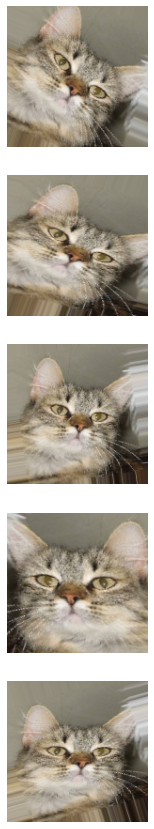

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

### Building the Model. 
A model is built below that will be used to predict the images. It includes a stack of Conv2D and MaxPooling2d layers. A final softmax layer decides whether the image is that of a dog or a cat.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 82944)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                5308480   
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

### Traing the model
The model is trained

In [ ]:
history = model.fit(train_data_gen, epochs=epochs,
                    steps_per_epoch=int(np.ceil(total_train / float(batch_size))), 
                    validation_data=val_data_gen,
                    validation_steps=int(np.ceil(total_val / float(batch_size)))
                    )

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
16/16 [==============================] - 72s 5s/step - loss: 0.8705 - accuracy: 0.4870 - val_loss: 0.6913 - val_accuracy: 0.5280
Epoch 2/10
16/16 [==============================] - 72s 5s/step - loss: 0.6857 - accuracy: 0.5765 - val_loss: 0.6729 - val_accuracy: 0.5500
Epoch 3/10
16/16 [==============================] - 73s 5s/step - loss: 0.6691 - accuracy: 0.6025 - val_loss: 0.6469 - val_accuracy: 0.6370
Epoch 4/10
16/16 [==============================] - 72s 4s/step - loss: 0.6300 - accuracy: 0.6295 - val_loss: 0.6210 - val_accuracy: 0.6500
Epoch 5/10
16/16 [==============================] - 71s 4s/step - loss: 0.6071 - accuracy: 0.6655 - val_loss: 0.6309 - val_accuracy: 0.6200
Epoch 6/10
16/16 [==============================] - 71s 4s/step - loss: 0.6060 - accuracy: 0.6530 - val_loss: 0.5799 - val_accuracy: 0.6850
Epoch 7/10
16/16 [==============================] - 77s 5s/step - loss: 0.5675 - accuracy: 0.7065 - val_loss: 0.5709 - val_accuracy: 0.6970
Epoch 8/10
16/16 [==

Visualizing the accuracy and loss of the model.

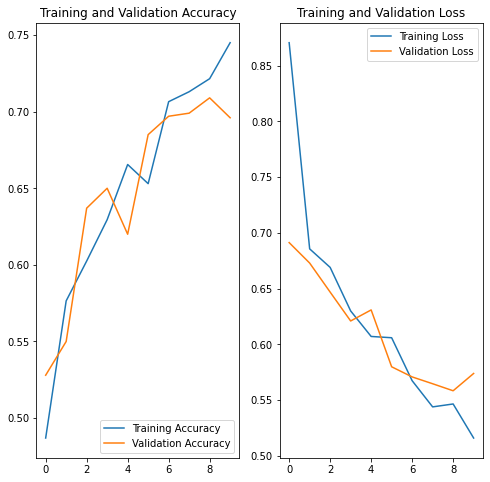

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Using the Model to predict whether the test images are images of cats or dogs.

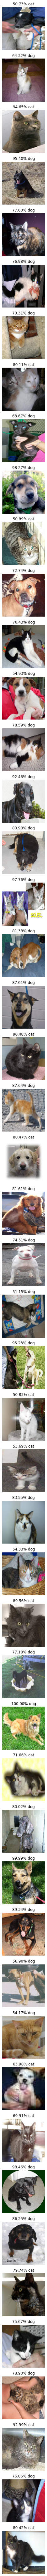

In [ ]:
probabilities = model.predict(test_data_gen)
prediction = model.predict_classes(test_data_gen)
plotImages([test_data_gen[i][0] for i in range(50)],probabilities=probabilities)

Testing to seee how good the model is

In [ ]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(prediction, answers):
  if probability == answer:
    correct +=1

percentage_identified = (correct / len(answers))*100

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("The model has passed testing.")
else:
  print("The Model is not accuarate enough.")

Your model correctly identified 66.0% of the images of cats and dogs.
The model has passed testing.
